In [1]:
import sys

sys.path.append("..")

import tensorflow as tf

import numpy as np

from utils import tf_config

dataset="01"
memory_limit=1500
interval_eeg=10

tf_config.set_seed(seed=2)#02 [2, 3, 5, 7, 11]
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit)

import GPyOpt

import argparse

from utils import preprocess_data, search_algorithms, train, losses_utils, metrics, eeg_utils, data_utils

from models import fmri_ae, eeg_to_fmri, uniconv_fmri

from layers import locally_connected

import matplotlib.pyplot as plt

import gc

import os

from sklearn.model_selection import train_test_split, KFold

from pathlib import Path

import time

import pickle

n_individuals=getattr(data_utils, "n_individuals_"+dataset)

with tf.device('/CPU:0'):
    train_data, test_data = preprocess_data.dataset(dataset, n_individuals=n_individuals,
                                            interval_eeg=interval_eeg, 
                                            ind_volume_fit=False,
                                            standardize_fmri=True,
                                            iqr=False,
                                            verbose=True)
    eeg_train, fmri_train =train_data
    eeg_test, fmri_test = test_data

2022-05-04 12:15:35.341449: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-04 12:15:36.669713: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-04 12:15:36.670198: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-04 12:15:36.712136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 12:15:36.712675: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-05-04 12:15:36.712700: I tensorflow/stream_executor/platform/def

I: Starting to Load Data
I: Finished Loading Data
I: Pairs Created


## Build fMRI AE

In [2]:
theta = (0.002980911194116198, 0.0004396489214334123, (9, 9, 4), (1, 1, 1), 4, (7, 7, 7), 4, True, True, True, True, 3, 1)

In [3]:
#unroll hyperparameters
learning_rate=float(theta[0])
weight_decay = float(theta[1])
kernel_size = theta[2]
stride_size = theta[3]
batch_size=int(theta[4])
latent_dimension=theta[5]
n_channels=int(theta[6])
max_pool=bool(theta[7])
batch_norm=bool(theta[8])
skip_connections=bool(theta[9])
dropout=bool(theta[10])
n_stacks=int(theta[11])
outfilter=int(theta[12])
local=True

In [4]:
with open(str(Path.home())+"/eeg_to_fmri/na_models_eeg/na_specification_2", "rb") as f:
    na_specification_eeg = pickle.load(f)
with open(str(Path.home())+"/eeg_to_fmri/na_models_fmri/na_specification_2", "rb") as f:
    na_specification_fmri = pickle.load(f)

In [5]:
import importlib
importlib.reload(eeg_to_fmri)
low_resolution_factor=1.5
resolution_decoder = (int(fmri_train.shape[1]/low_resolution_factor),
                     int(fmri_train.shape[2]/low_resolution_factor),
                     int(fmri_train.shape[3]/low_resolution_factor))

with tf.device('/CPU:0'):
    model = eeg_to_fmri.EEG_to_fMRI(latent_dimension, eeg_train.shape[1:], na_specification_eeg, n_channels,
                        weight_decay=weight_decay, skip_connections=True,
                        batch_norm=True, #dropout=False,
                        fourier_features=True,
                        random_fourier=True,
                        topographical_attention=True,
                        conditional_attention_style=True,
                        conditional_attention_style_prior=False,
                        inverse_DFT=True, DFT=True,
                        variational_iDFT=True,
                        variational_coefs=(5,5,5),
                        variational_iDFT_dependent=True,
                        variational_iDFT_dependent_dim=10,
                        aleatoric_uncertainty=True,#to compute aleatoric uncertainty
                        low_resolution_decoder=True,
                        resolution_decoder=resolution_decoder,#experimenting
                        local=True, seed=None, 
                        fmri_args = (latent_dimension, fmri_train.shape[1:], 
                        kernel_size, stride_size, n_channels, 
                        max_pool, batch_norm, weight_decay, skip_connections,
                        n_stacks, True, False, outfilter, dropout, None, False, na_specification_fmri))
    
    model.build(eeg_train.shape, fmri_train.shape)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    loss_fn = losses_utils.Laplacian_Loss

    train_set = tf.data.Dataset.from_tensor_slices((eeg_train, fmri_train)).batch(batch_size)
    dev_set= tf.data.Dataset.from_tensor_slices((eeg_test, fmri_test)).batch(1)

2022-05-04 12:16:34.235818: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 787619840 exceeds 10% of free system memory.
2022-05-04 12:16:34.374306: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1128529920 exceeds 10% of free system memory.


In [6]:
loss_history = train.train(train_set, model, optimizer, 
                            loss_fn, epochs=10, 
                            u_architecture=True,
                            val_set=None, verbose=True, verbose_batch=True)[0]

2022-05-04 12:16:34.612006: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 787619840 exceeds 10% of free system memory.
2022-05-04 12:16:34.959081: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1128529920 exceeds 10% of free system memory.
2022-05-04 12:16:37.116379: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-04 12:16:37.127832: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699910000 Hz
2022-05-04 12:16:37.486007: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-04 12:16:37.850386: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-05-04 12:16:37.877459: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-05-04 12

Batch ... with loss: 2.5603123
Batch ... with loss: 2.4557562
Batch ... with loss: 2.3537095
Batch ... with loss: 2.3070226
Batch ... with loss: 2.3018384
Batch ... with loss: 2.3023875
Batch ... with loss: 2.296597
Batch ... with loss: 2.2918205
Batch ... with loss: 2.2871666
Batch ... with loss: 2.2856033
Batch ... with loss: 2.2837687
Batch ... with loss: 2.2840223
Batch ... with loss: 2.2824633
Batch ... with loss: 2.2803988
Batch ... with loss: 2.2820883
Batch ... with loss: 2.2816305
Batch ... with loss: 2.275566
Batch ... with loss: 2.2789497
Batch ... with loss: 2.2740579
Batch ... with loss: 2.2815776
Batch ... with loss: 2.2745333
Batch ... with loss: 2.2773232
Batch ... with loss: 2.2724357
Batch ... with loss: 2.2732842
Batch ... with loss: 2.273376
Batch ... with loss: 2.2638412
Batch ... with loss: 2.265791
Batch ... with loss: 2.2652054
Batch ... with loss: 2.2714224
Batch ... with loss: 2.2735255
Batch ... with loss: 2.271964
Batch ... with loss: 2.2730322
Batch ... wit

Batch ... with loss: 0.8742714
Batch ... with loss: 0.7667576
Batch ... with loss: 0.7626241
Batch ... with loss: 0.78336287
Batch ... with loss: 0.7744924
Batch ... with loss: 0.8779639
Batch ... with loss: 0.7642603
Batch ... with loss: 0.739114
Batch ... with loss: 0.78540945
Batch ... with loss: 0.74742573
Batch ... with loss: 0.9097232
Batch ... with loss: 0.70749426
Batch ... with loss: 0.7405944
Batch ... with loss: 0.8629496
Batch ... with loss: 0.81319577
Batch ... with loss: 0.90652263
Batch ... with loss: 0.80886465
Batch ... with loss: 0.7247806
Batch ... with loss: 0.7546277
Batch ... with loss: 0.7291024
Batch ... with loss: 0.8258947
Batch ... with loss: 0.9289465
Batch ... with loss: 1.0899475
Batch ... with loss: 0.9247232
Batch ... with loss: 0.95457244
Batch ... with loss: 0.93290085
Batch ... with loss: 1.0636643
Batch ... with loss: 1.0188541
Batch ... with loss: 0.92887473
Batch ... with loss: 0.8226987
Batch ... with loss: 0.86599916
Batch ... with loss: 0.793757

Batch ... with loss: 0.42085642
Batch ... with loss: 0.4819613
Batch ... with loss: 0.42635202
Batch ... with loss: 0.43144143
Batch ... with loss: 0.41322207
Batch ... with loss: 0.41371724
Batch ... with loss: 0.37630934
Batch ... with loss: 0.4312157
Batch ... with loss: 0.4002333
Batch ... with loss: 0.35506386
Batch ... with loss: 0.37029576
Batch ... with loss: 0.3647663
Batch ... with loss: 0.40831006
Batch ... with loss: 0.53734493
Batch ... with loss: 0.3460375
Batch ... with loss: 0.34257594
Batch ... with loss: 0.37004113
Batch ... with loss: 0.35590082
Batch ... with loss: 0.32333073
Batch ... with loss: 0.356175
Batch ... with loss: 0.2959343
Batch ... with loss: 0.32032004
Batch ... with loss: 0.35616124
Batch ... with loss: 0.33162868
Batch ... with loss: 0.32418168
Batch ... with loss: 0.38707784
Batch ... with loss: 0.32197624
Batch ... with loss: 0.34149384
Batch ... with loss: 0.35595638
Batch ... with loss: 0.3720616
Batch ... with loss: 0.36192632
Batch ... with lo

2022-05-04 12:23:44.356209: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 787619840 exceeds 10% of free system memory.


Batch ... with loss: 0.8270774
Batch ... with loss: 0.716545
Batch ... with loss: 0.686649
Batch ... with loss: 0.68816376
Batch ... with loss: 0.64317346
Batch ... with loss: 0.72621906
Batch ... with loss: 0.67524517
Batch ... with loss: 0.5714607
Batch ... with loss: 0.5997354
Batch ... with loss: 0.5006344
Batch ... with loss: 0.6471889
Batch ... with loss: 0.48307562
Batch ... with loss: 0.47835207
Batch ... with loss: 0.513288
Batch ... with loss: 0.6234368
Batch ... with loss: 0.44917792
Batch ... with loss: 0.5255094
Batch ... with loss: 0.5263337
Batch ... with loss: 0.42296252
Batch ... with loss: 0.3825134
Batch ... with loss: 0.41438437
Batch ... with loss: 0.40353554
Batch ... with loss: 0.39245
Batch ... with loss: 0.4035189
Batch ... with loss: 0.52106506
Batch ... with loss: 0.4749446
Batch ... with loss: 0.4785475
Batch ... with loss: 0.4910585
Batch ... with loss: 0.5121221
Batch ... with loss: 0.5861527
Batch ... with loss: 0.5135859
Batch ... with loss: 0.3870769
Ba

Batch ... with loss: 0.531291
Batch ... with loss: 0.37784344
Batch ... with loss: 0.36813277
Batch ... with loss: 0.42027825
Batch ... with loss: 0.45561934
Batch ... with loss: 0.44684932
Batch ... with loss: 0.43494397
Batch ... with loss: 0.45236593
Batch ... with loss: 0.586625
Batch ... with loss: 0.37414435
Batch ... with loss: 0.37173945
Batch ... with loss: 0.5162963
Batch ... with loss: 0.7046472
Batch ... with loss: 0.36503065
Batch ... with loss: 0.3484202
Batch ... with loss: 0.4697777
Batch ... with loss: 0.35911205
Batch ... with loss: 0.38352445
Batch ... with loss: 0.3735618
Batch ... with loss: 0.36081523
Batch ... with loss: 0.3789276
Batch ... with loss: 0.4377062
Batch ... with loss: 0.34510848
Batch ... with loss: 0.3860523
Batch ... with loss: 0.4168095
Batch ... with loss: 0.3553062
Batch ... with loss: 0.5335196
Batch ... with loss: 1.2246978
Batch ... with loss: 0.80164915
Batch ... with loss: 0.9476683
Batch ... with loss: 0.68258804
Batch ... with loss: 0.52

Batch ... with loss: 0.27100617
Batch ... with loss: 0.241855
Batch ... with loss: 0.38544658
Batch ... with loss: 0.35234523
Batch ... with loss: 0.2142686
Batch ... with loss: 0.24484512
Batch ... with loss: 0.31142753
Batch ... with loss: 0.27045947
Batch ... with loss: 0.2533362
Batch ... with loss: 0.23956811
Batch ... with loss: 0.18549801
Batch ... with loss: 0.19064885
Batch ... with loss: 0.22483903
Batch ... with loss: 0.18412621
Batch ... with loss: 0.14690973
Batch ... with loss: 0.1579211
Batch ... with loss: 0.13692734
Batch ... with loss: 0.16676882
Batch ... with loss: 0.17477578
Batch ... with loss: 0.13112427
Batch ... with loss: 0.14622986
Batch ... with loss: 0.28037712
Batch ... with loss: 0.1898901
Batch ... with loss: 0.13919449
Batch ... with loss: 0.113977775
Batch ... with loss: 0.12028298
Batch ... with loss: 0.22605908
Batch ... with loss: 0.11662106
Batch ... with loss: 0.09929502
Batch ... with loss: 0.14578004
Batch ... with loss: 0.15939936
Batch ... wit

Batch ... with loss: 0.16717394
Batch ... with loss: 0.27943417
Batch ... with loss: 0.20627615
Batch ... with loss: 0.18863437
Batch ... with loss: 0.1767884
Batch ... with loss: 0.26776448
Batch ... with loss: 0.39348096
Batch ... with loss: 0.24967206
Batch ... with loss: 0.15458293
Batch ... with loss: 0.2650462
Batch ... with loss: 0.30881852
Batch ... with loss: 0.22493479
Batch ... with loss: 1.0371975
Batch ... with loss: 0.94751096
Batch ... with loss: 0.9377744
Batch ... with loss: 0.91549563
Batch ... with loss: 0.7984988
Batch ... with loss: 0.73530865
Batch ... with loss: 0.62042296
Batch ... with loss: 0.78467685
Batch ... with loss: 0.5894203
Batch ... with loss: 0.4809282
Batch ... with loss: 0.42270353
Batch ... with loss: 0.5082335
Batch ... with loss: 0.42600876
Batch ... with loss: 0.38863945
Batch ... with loss: 0.36278152
Batch ... with loss: 0.34139356
Batch ... with loss: 0.33715063
Batch ... with loss: 0.2975534
Batch ... with loss: 0.32745418
Batch ... with lo

Batch ... with loss: 0.23189312
Batch ... with loss: 0.2536608
Batch ... with loss: 0.19302095
Batch ... with loss: 0.23038752
Batch ... with loss: 0.21806529
Batch ... with loss: 0.1971288
Batch ... with loss: 0.26860482
Batch ... with loss: 0.18787098
Batch ... with loss: 0.20159844
Batch ... with loss: 0.16986504
Batch ... with loss: 0.17071292
Batch ... with loss: 0.16760668
Batch ... with loss: 0.24708194
Batch ... with loss: 0.2034882
Batch ... with loss: 0.17469715
Batch ... with loss: 0.16963552
Batch ... with loss: 0.22321734
Batch ... with loss: 0.21115555
Batch ... with loss: 0.16924445
Batch ... with loss: 0.16603343
Batch ... with loss: 0.16806981
Batch ... with loss: 0.20389816
Batch ... with loss: 0.20684436
Batch ... with loss: 0.19023722
Batch ... with loss: 0.17870423
Batch ... with loss: 0.2636171
Batch ... with loss: 0.22744128
Batch ... with loss: 0.15552136
Batch ... with loss: 0.14776923
Batch ... with loss: 0.19094709
Batch ... with loss: 0.14462546
Batch ... wi

Batch ... with loss: 0.7884104
Batch ... with loss: 0.7300884
Batch ... with loss: 0.69421494
Batch ... with loss: 0.6691992
Batch ... with loss: 0.6315023
Batch ... with loss: 0.504678
Batch ... with loss: 0.34226763
Batch ... with loss: 0.4147187
Batch ... with loss: 0.24524033
Batch ... with loss: 0.21885258
Batch ... with loss: 0.27693337
Batch ... with loss: 0.23592103
Batch ... with loss: 0.20134805
Batch ... with loss: 0.16224955
Batch ... with loss: 0.16569814
Batch ... with loss: 0.17586756
Batch ... with loss: 0.27626812
Batch ... with loss: 0.18096796
Batch ... with loss: 0.177002
Batch ... with loss: 0.16264112
Batch ... with loss: 0.12622786
Batch ... with loss: 0.27095884
Batch ... with loss: 0.22008038
Batch ... with loss: 0.17170776
Batch ... with loss: 0.18430433
Batch ... with loss: 0.22045147
Batch ... with loss: 0.14639649
Batch ... with loss: 0.15176235
Batch ... with loss: 0.142383
Batch ... with loss: 0.19416945
Batch ... with loss: 0.18275267
Batch ... with loss

Batch ... with loss: 0.43257886
Batch ... with loss: 0.33975205
Batch ... with loss: 0.33042663
Batch ... with loss: 0.2602767
Batch ... with loss: 0.24436706
Batch ... with loss: 0.25132117
Batch ... with loss: 0.25757676
Batch ... with loss: 0.2563989
Batch ... with loss: 0.22826263
Batch ... with loss: 0.26701972
Batch ... with loss: 0.23416755
Batch ... with loss: 0.22307697
Batch ... with loss: 0.26734504
Batch ... with loss: 0.24371062
Batch ... with loss: 0.2052755
Batch ... with loss: 0.21517119
Batch ... with loss: 0.23692165
Batch ... with loss: 0.26570448
Batch ... with loss: 0.2120974
Batch ... with loss: 0.26396894
Batch ... with loss: 0.2744123
Batch ... with loss: 0.26434237
Batch ... with loss: 0.23064488
Batch ... with loss: 0.25872922
Batch ... with loss: 0.2361162
Batch ... with loss: 0.23214732
Batch ... with loss: 0.31073147
Batch ... with loss: 0.5988226
Batch ... with loss: 0.30795634
Batch ... with loss: 0.665891
Batch ... with loss: 1.0329788
Batch ... with los

Batch ... with loss: 0.4353019
Batch ... with loss: 0.36642894
Batch ... with loss: 0.2645623
Batch ... with loss: 0.24201146
Batch ... with loss: 0.32717443
Batch ... with loss: 0.22822955
Batch ... with loss: 0.22655633
Batch ... with loss: 0.1326727
Batch ... with loss: 0.08307278
Batch ... with loss: 0.07752597
Batch ... with loss: 0.13514674
Batch ... with loss: 0.09742536
Batch ... with loss: 0.082869515
Batch ... with loss: 0.0228533
Batch ... with loss: 0.026484832
Batch ... with loss: 0.046031833
Batch ... with loss: 0.07072149
Batch ... with loss: 0.071906164
Batch ... with loss: 0.020638049
Batch ... with loss: 0.030842766
Batch ... with loss: 0.0052078813
Batch ... with loss: 0.010687232
Batch ... with loss: 0.0030035228
Batch ... with loss: -0.02662398
Batch ... with loss: -0.0070901066
Batch ... with loss: -0.0063489825
Batch ... with loss: -0.029299915
Batch ... with loss: -0.039612293
Batch ... with loss: 0.07326561
Batch ... with loss: -0.008982867
Batch ... with loss:

Batch ... with loss: -0.11910167
Batch ... with loss: -0.1353268
Batch ... with loss: -0.1790496
Batch ... with loss: -0.15016595
Batch ... with loss: -0.13633944
Batch ... with loss: -0.1181376
Batch ... with loss: -0.09441881
Batch ... with loss: -0.09791507
Batch ... with loss: -0.1280664
Batch ... with loss: -0.10676962
Batch ... with loss: -0.10288113
Batch ... with loss: -0.1454126
Batch ... with loss: -0.07882258
Batch ... with loss: -0.054367706
Batch ... with loss: -0.05794692
Batch ... with loss: -0.102500275
Batch ... with loss: -0.13615637
Batch ... with loss: -0.1785996
Batch ... with loss: -0.17213559
Batch ... with loss: -0.17947306
Batch ... with loss: -0.16780451
Batch ... with loss: -0.14030893
Batch ... with loss: -0.14986405
Batch ... with loss: 0.34221432
Batch ... with loss: 1.9746379
Batch ... with loss: 1.8337421
Batch ... with loss: 1.6663775
Batch ... with loss: 1.2582185
Batch ... with loss: 1.2809038
Batch ... with loss: 1.0256853
Batch ... with loss: 0.6996

Batch ... with loss: -0.04245147
Batch ... with loss: -0.0601082
Batch ... with loss: 0.13212131
Batch ... with loss: 0.13293113
Batch ... with loss: 0.12627745
Batch ... with loss: 0.041947037
Batch ... with loss: -0.03553018
Batch ... with loss: -0.07447171
Batch ... with loss: 0.034918636
Batch ... with loss: -0.018134773
Batch ... with loss: -0.0018997043
Batch ... with loss: 0.121247694
Batch ... with loss: -0.008519843
Batch ... with loss: -0.020336673
Batch ... with loss: 0.10917468
Batch ... with loss: 0.06773677
Batch ... with loss: 0.17300056
Batch ... with loss: 0.0577351
Batch ... with loss: 0.07086955
Batch ... with loss: -0.02850695
Batch ... with loss: -0.06913963
Batch ... with loss: -0.015618011
Batch ... with loss: 0.03423643
Batch ... with loss: 0.2068766
Batch ... with loss: 0.08209361
Batch ... with loss: -0.10908079
Batch ... with loss: -0.022757977
Batch ... with loss: -0.03890188
Batch ... with loss: -0.014512122
Batch ... with loss: 0.22587448
Batch ... with lo

Batch ... with loss: 0.016413793
Batch ... with loss: -0.07686263
Batch ... with loss: -0.08525424
Batch ... with loss: -0.062222153
Batch ... with loss: 0.029619545
Batch ... with loss: 0.0657129
Batch ... with loss: -0.0002799034
Batch ... with loss: -0.066794634
Batch ... with loss: -0.010244265
Batch ... with loss: 0.028135166
Batch ... with loss: -0.004690945
Batch ... with loss: -0.039241508
Batch ... with loss: -0.06395221
Batch ... with loss: -0.05122876
Batch ... with loss: -0.09537384
Batch ... with loss: -0.0035430938
Batch ... with loss: 0.07764207
Batch ... with loss: -0.005211279
Batch ... with loss: -0.0129600465
Batch ... with loss: -0.080213144
Batch ... with loss: -0.08797115
Batch ... with loss: 0.018340915
Batch ... with loss: 0.035252124
Batch ... with loss: 0.7702951
Batch ... with loss: 0.733865
Batch ... with loss: 0.57620525
Batch ... with loss: 0.40563545
Batch ... with loss: 0.2708415
Batch ... with loss: 0.23354137
Batch ... with loss: 0.1205958
Batch ... wi

Batch ... with loss: 0.11278209
Batch ... with loss: 0.14549278
Batch ... with loss: 0.16434017
Batch ... with loss: 0.03316824
Batch ... with loss: 0.03651741
Batch ... with loss: 0.13738123
Batch ... with loss: 0.13872598
Batch ... with loss: 0.20719011
Batch ... with loss: 0.13666242
Batch ... with loss: 0.089281395
Batch ... with loss: 0.13794318
Batch ... with loss: 0.067121044
Batch ... with loss: 0.002615139
Batch ... with loss: -0.026889011
Batch ... with loss: 0.10997753
Batch ... with loss: 0.15065768
Batch ... with loss: 0.1748831
Batch ... with loss: 0.020290226
Batch ... with loss: -0.07485819
Batch ... with loss: -0.088511586
Batch ... with loss: -0.079219535
Batch ... with loss: -0.1038585
Batch ... with loss: -0.028686598
Batch ... with loss: -0.070555985
Batch ... with loss: -0.08805373
Batch ... with loss: -0.057165146
Batch ... with loss: -0.130834
Batch ... with loss: -0.11565128
Batch ... with loss: -0.10047443
Batch ... with loss: -0.07648185
Batch ... with loss: 

Batch ... with loss: -0.13057703
Batch ... with loss: -0.17304216
Batch ... with loss: -0.19892323
Batch ... with loss: -0.19359882
Batch ... with loss: -0.18885076
Batch ... with loss: -0.19450134
Batch ... with loss: -0.19057536
Batch ... with loss: -0.20317227
Batch ... with loss: -0.2265575
Batch ... with loss: -0.22483592
Batch ... with loss: -0.19543019
Batch ... with loss: -0.2046159
Batch ... with loss: -0.19828828
Batch ... with loss: -0.18946642
Batch ... with loss: -0.21023998
Batch ... with loss: -0.19883662
Batch ... with loss: -0.21497817
Batch ... with loss: -0.19984733
Batch ... with loss: -0.22817019
Batch ... with loss: -0.20780414
Batch ... with loss: -0.20582347
Batch ... with loss: -0.2268945
Batch ... with loss: -0.22857009
Batch ... with loss: 0.63906246
Batch ... with loss: 0.97123
Batch ... with loss: 0.925043
Batch ... with loss: 0.9856738
Batch ... with loss: 0.93906355
Batch ... with loss: 0.76072073
Batch ... with loss: 0.7272996
Batch ... with loss: 0.5884

Batch ... with loss: 0.11458339
Batch ... with loss: 0.049364313
Batch ... with loss: 0.03902021
Batch ... with loss: 0.039850578
Batch ... with loss: -0.0044736415
Batch ... with loss: -0.041989
Batch ... with loss: 0.052840307
Batch ... with loss: -0.028753147
Batch ... with loss: -0.08211818
Batch ... with loss: -0.11368561
Batch ... with loss: -0.10527223
Batch ... with loss: -0.0067365468
Batch ... with loss: -0.09985994
Batch ... with loss: -0.08422805
Batch ... with loss: -0.11722566
Batch ... with loss: -0.10670544
Batch ... with loss: -0.13563848
Batch ... with loss: -0.14744484
Batch ... with loss: -0.17076351
Batch ... with loss: -0.15640868
Batch ... with loss: -0.15938553
Batch ... with loss: -0.14914471
Batch ... with loss: -0.17366935
Batch ... with loss: -0.14992417
Batch ... with loss: -0.14379655
Batch ... with loss: -0.17789783
Batch ... with loss: -0.1646025
Batch ... with loss: -0.16882409
Batch ... with loss: -0.13672693
Batch ... with loss: -0.14545813
Batch ... 

Batch ... with loss: -0.19982718
Batch ... with loss: -0.21579665
Batch ... with loss: -0.17732275
Batch ... with loss: -0.17593789
Batch ... with loss: -0.23708457
Batch ... with loss: -0.20794031
Batch ... with loss: -0.15204902
Batch ... with loss: -0.16827169
Batch ... with loss: -0.18247159
Batch ... with loss: -0.22752632
Batch ... with loss: -0.21880396
Batch ... with loss: -0.17606653
Batch ... with loss: -0.07696457
Batch ... with loss: -0.1113767
Batch ... with loss: -0.12579231
Batch ... with loss: -0.20810558
Batch ... with loss: -0.1808847
Batch ... with loss: -0.20173743
Batch ... with loss: -0.22269505
Batch ... with loss: -0.13677363
Batch ... with loss: -0.18354808
Batch ... with loss: -0.15120904
Batch ... with loss: -0.23556206
Batch ... with loss: -0.23237604
Batch ... with loss: 0.29860443
Batch ... with loss: 0.836692
Batch ... with loss: 0.8292438
Batch ... with loss: 0.77591586
Batch ... with loss: 0.81477106
Batch ... with loss: 0.6947006
Batch ... with loss: 0

Batch ... with loss: 0.9396701
Batch ... with loss: 0.44457376
Batch ... with loss: 0.32423112
Batch ... with loss: 0.40584663
Batch ... with loss: 0.4361658
Batch ... with loss: 0.3875176
Batch ... with loss: 0.43769062
Batch ... with loss: 0.39138955
Batch ... with loss: 0.74892515
Batch ... with loss: 0.65864503
Batch ... with loss: 0.3013714
Batch ... with loss: 0.21704024
Batch ... with loss: 0.34741175
Batch ... with loss: 0.41133177
Batch ... with loss: 0.37096813
Batch ... with loss: 0.4855247
Batch ... with loss: 0.42176187
Batch ... with loss: 0.25271773
Batch ... with loss: 0.08779001
Batch ... with loss: 0.051353157
Batch ... with loss: 0.10058375
Batch ... with loss: 0.19194312
Batch ... with loss: 0.13867816
Batch ... with loss: 0.09888266
Batch ... with loss: 0.13915756
Batch ... with loss: 0.17524989
Batch ... with loss: 0.034806266
Batch ... with loss: 0.124620855
Batch ... with loss: 0.107275575
Batch ... with loss: 0.2159646
Batch ... with loss: 0.08381896
Batch ... 

Batch ... with loss: 0.09395082
Batch ... with loss: -0.1451608
Batch ... with loss: -0.15178937
Batch ... with loss: -0.20811418
Batch ... with loss: -0.11363059
Batch ... with loss: -0.030359015
Batch ... with loss: -0.040415943
Batch ... with loss: 0.018520817
Batch ... with loss: -0.09819478
Batch ... with loss: -0.12946227
Batch ... with loss: -0.1544802
Batch ... with loss: -0.11406715
Batch ... with loss: -0.1706237
Batch ... with loss: -0.053450167
Batch ... with loss: -0.15982006
Batch ... with loss: -0.11401689
Batch ... with loss: -0.17182389
Batch ... with loss: -0.18523778
Batch ... with loss: -0.17986493
Batch ... with loss: -0.1632073
Batch ... with loss: -0.08290398
Batch ... with loss: 0.0010499507
Batch ... with loss: -0.041886613
Batch ... with loss: -0.15515508
Batch ... with loss: -0.17713135
Batch ... with loss: -0.0745304
Batch ... with loss: 0.40792567
Batch ... with loss: 0.44799852
Batch ... with loss: 0.40931714
Batch ... with loss: 0.40615547
Batch ... with 

Batch ... with loss: -0.15556982
Batch ... with loss: -0.1868862
Batch ... with loss: -0.19669335
Batch ... with loss: -0.15414132
Batch ... with loss: -0.16634245
Batch ... with loss: -0.12661617
Batch ... with loss: -0.1942382
Batch ... with loss: -0.24477394
Batch ... with loss: -0.17959914
Batch ... with loss: -0.15857251
Batch ... with loss: -0.16208132
Batch ... with loss: -0.1607049
Batch ... with loss: -0.15278955
Batch ... with loss: -0.22141173
Batch ... with loss: -0.21775153
Batch ... with loss: -0.23678173
Batch ... with loss: -0.21123554
Batch ... with loss: -0.1698166
Batch ... with loss: -0.19827291
Batch ... with loss: -0.22158132
Batch ... with loss: -0.24574451
Batch ... with loss: -0.2830879
Batch ... with loss: -0.2496792
Batch ... with loss: -0.23671134
Batch ... with loss: -0.17570882
Batch ... with loss: -0.19596224
Batch ... with loss: -0.24341571
Batch ... with loss: -0.21188222
Batch ... with loss: -0.21763715
Batch ... with loss: -0.27459976
Batch ... with l

Batch ... with loss: -0.1733917
Batch ... with loss: -0.19081034
Batch ... with loss: -0.07636833
Batch ... with loss: 0.052301913
Batch ... with loss: 0.047492325
Batch ... with loss: 0.064750805
Batch ... with loss: 0.09357217
Batch ... with loss: 0.111615196
Batch ... with loss: -0.003536731
Batch ... with loss: -0.05519198
Batch ... with loss: -0.102991134
Batch ... with loss: -0.11909422
Batch ... with loss: -0.12411483
Batch ... with loss: 0.007217899
Batch ... with loss: -0.03394237
Batch ... with loss: 0.05671248
Batch ... with loss: 0.13482042
Batch ... with loss: -0.0017430484
Batch ... with loss: -0.06761445
Batch ... with loss: -0.19270545
Batch ... with loss: -0.14411458
Batch ... with loss: -0.202498
Batch ... with loss: -0.14550848
Batch ... with loss: -0.14406787
Batch ... with loss: -0.10843468
Batch ... with loss: 0.00710693
Epoch 9 with loss: 0.010103954800537654
Batch ... with loss: 0.41370076
Batch ... with loss: 0.2901305
Batch ... with loss: 0.14027631
Batch ... 

Batch ... with loss: 0.4448176
Batch ... with loss: 0.4390849
Batch ... with loss: 0.28495532
Batch ... with loss: 0.12367794
Batch ... with loss: 0.063457444
Batch ... with loss: 0.2571982
Batch ... with loss: 0.10451181
Batch ... with loss: 0.14064331
Batch ... with loss: 0.13868983
Batch ... with loss: 0.063058496
Batch ... with loss: 0.044583604
Batch ... with loss: -0.031185925
Batch ... with loss: -0.094981536
Batch ... with loss: -0.09608999
Batch ... with loss: -0.08344707
Batch ... with loss: -0.091343984
Batch ... with loss: -0.09834185
Batch ... with loss: -0.10284817
Batch ... with loss: -0.088812575
Batch ... with loss: -0.08526392
Batch ... with loss: -0.09462881
Batch ... with loss: -0.087091535
Batch ... with loss: -0.051117063
Batch ... with loss: -0.12788951
Batch ... with loss: -0.119767755
Batch ... with loss: -0.089883134
Batch ... with loss: -0.102030426
Batch ... with loss: -0.121953934
Batch ... with loss: -0.0962867
Batch ... with loss: -0.037561074
Batch ... w

Batch ... with loss: -0.17324822
Batch ... with loss: -0.17413953
Batch ... with loss: -0.17786607
Batch ... with loss: -0.1740457
Batch ... with loss: -0.14716125
Batch ... with loss: -0.17089802
Batch ... with loss: -0.18799981
Batch ... with loss: -0.11090711
Batch ... with loss: -0.05415082
Batch ... with loss: -0.07291527
Batch ... with loss: -0.09939206
Batch ... with loss: -0.14969125
Batch ... with loss: -0.15690918
Batch ... with loss: -0.19005498
Batch ... with loss: -0.16243657
Batch ... with loss: -0.0835315
Batch ... with loss: -0.104761675
Batch ... with loss: -0.1319599
Batch ... with loss: -0.09949161
Batch ... with loss: -0.16777782
Batch ... with loss: -0.17612673
Batch ... with loss: -0.04203759
Batch ... with loss: -0.09719497
Batch ... with loss: -0.07176046
Batch ... with loss: -0.17625606
Batch ... with loss: -0.15276998
Batch ... with loss: -0.15279995
Batch ... with loss: 0.419944
Batch ... with loss: 0.4920439
Batch ... with loss: 0.32807398
Batch ... with los

## Prediction vs ground truth plot

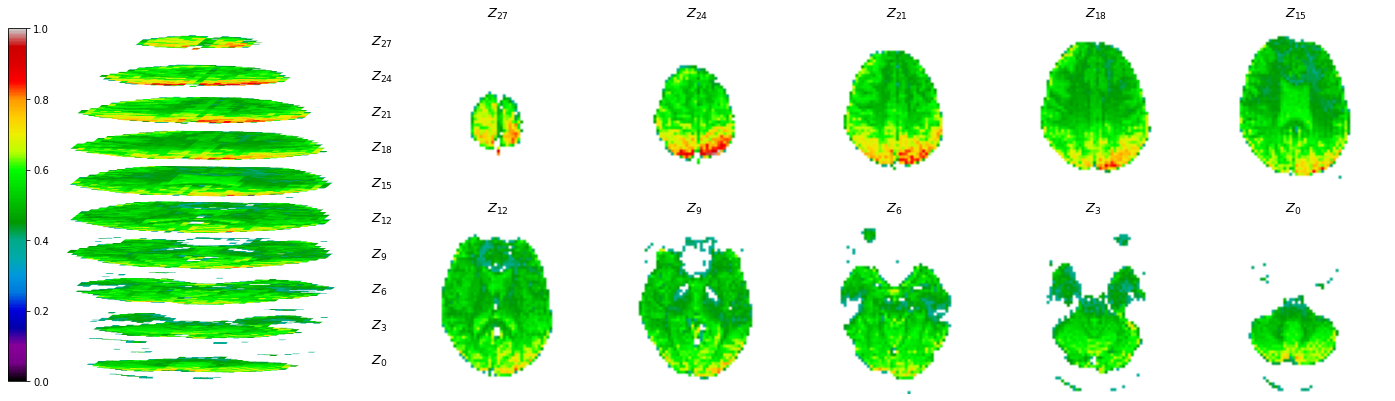

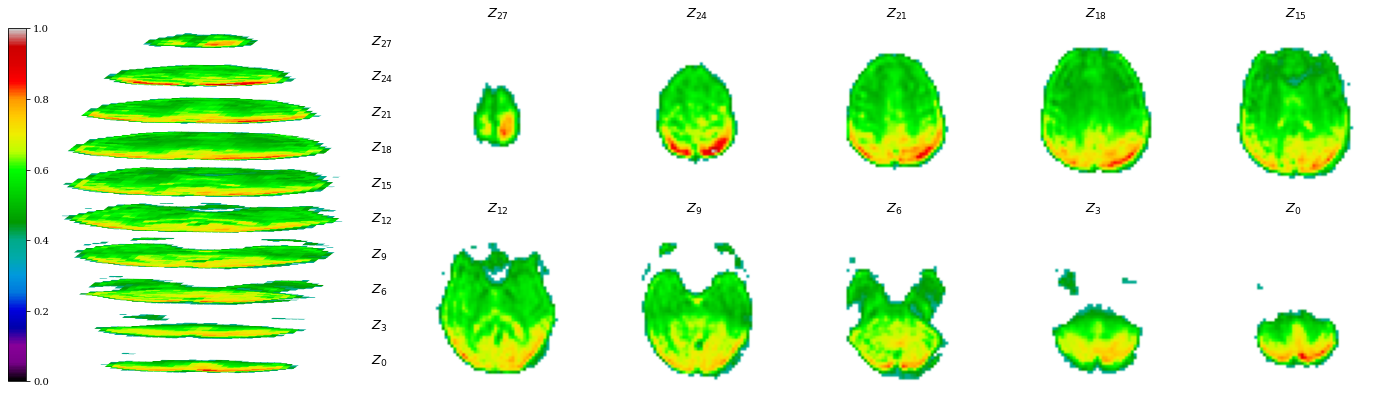

In [7]:
from utils import viz_utils, bnn_utils

save_path = "/home/ist_davidcalhas/eeg_to_fmri/plots/100_instances/"
plot_format="png"

instance = 1
for instance_x, instance_y in dev_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(instance_y.numpy()[0],
                                                           threshold=0.37)
    #plt.savefig(save_path + str(instance) + "_ground_truth."+plot_format, format=plot_format)
    fig.show()
    
    fig = viz_utils.plot_3D_representation_projected_slices(np.mean(bnn_utils.predict_MC(model, (instance_x, instance_y), T=100), axis=0),
                                                            threshold=0.37,)
    #plt.savefig(save_path + str(instance) + "_predicted."+plot_format, format=plot_format)
    fig.show() 
    instance += 1
    break

## Structural Similarity Index

In [8]:
ssim=metrics.ssim(dev_set, model)
print(np.mean(ssim), np.std(ssim))
rmse=metrics.rmse(dev_set, model)
print(np.mean(rmse), np.std(rmse))

0.4569451525028575 0.01555119911055082
0.4169077 0.02861524


In [9]:
from utils import lrp
explainer = lrp.LRP(model.fmri_encoder)
R=lrp.explain(explainer, dev_set, eeg=False, fmri=True, verbose=True)

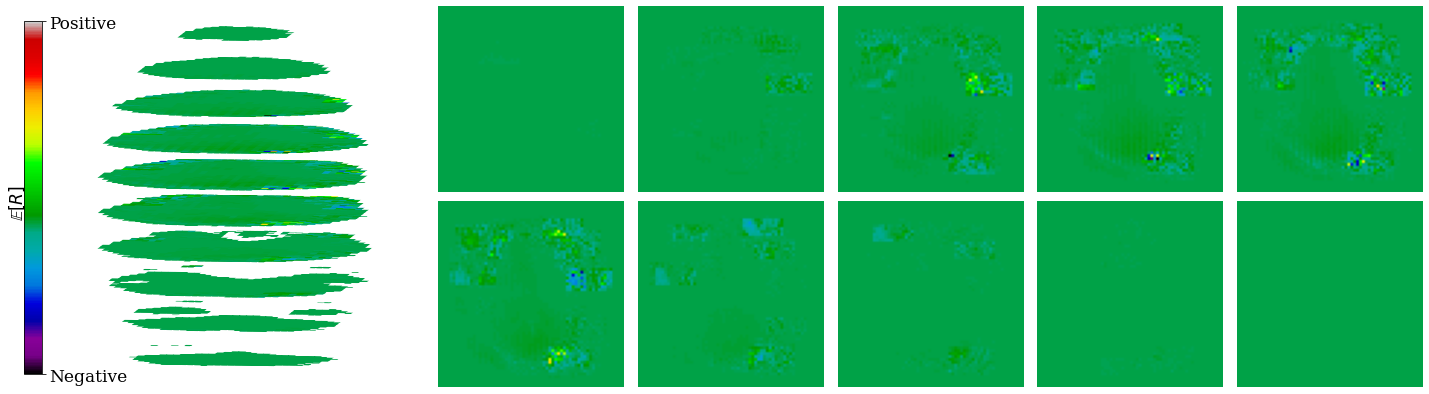

In [10]:
fig = viz_utils.plot_3D_representation_projected_slices(np.mean(R, axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=True, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Negative","Positive"])

### Compute uncertainty

In [11]:
from utils import bnn_utils

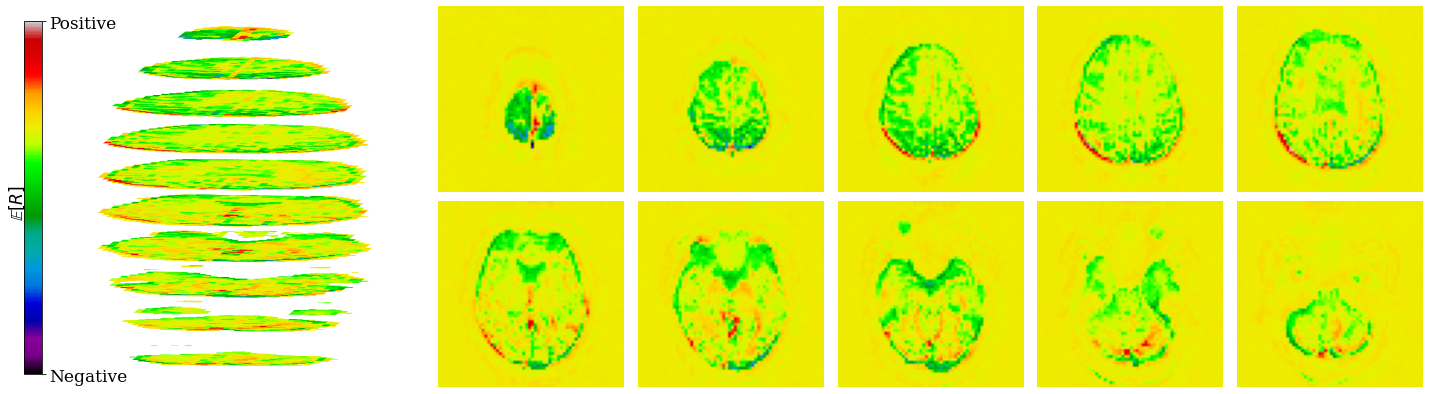

In [12]:
for instance_x, instance_y in dev_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(np.mean(bnn_utils.epistemic_uncertainty(model, (instance_x, instance_y), T=100), axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Negative","Positive"])
    fig.show()
    break

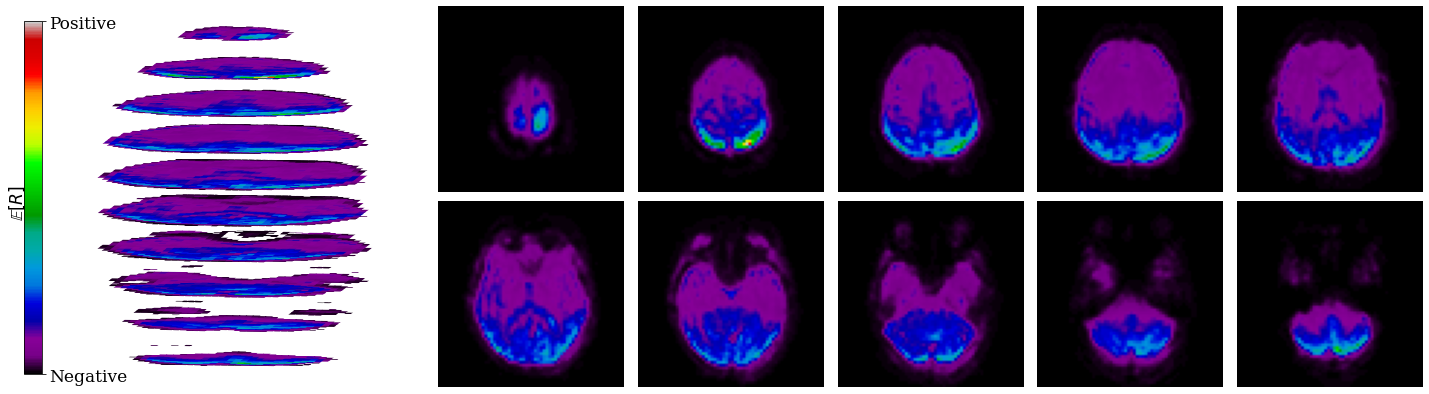

In [13]:
for instance_x, instance_y in dev_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(np.mean(bnn_utils.aleatoric_uncertainty(model, (instance_x, instance_y), T=100), axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Negative","Positive"])
    fig.show()
    break

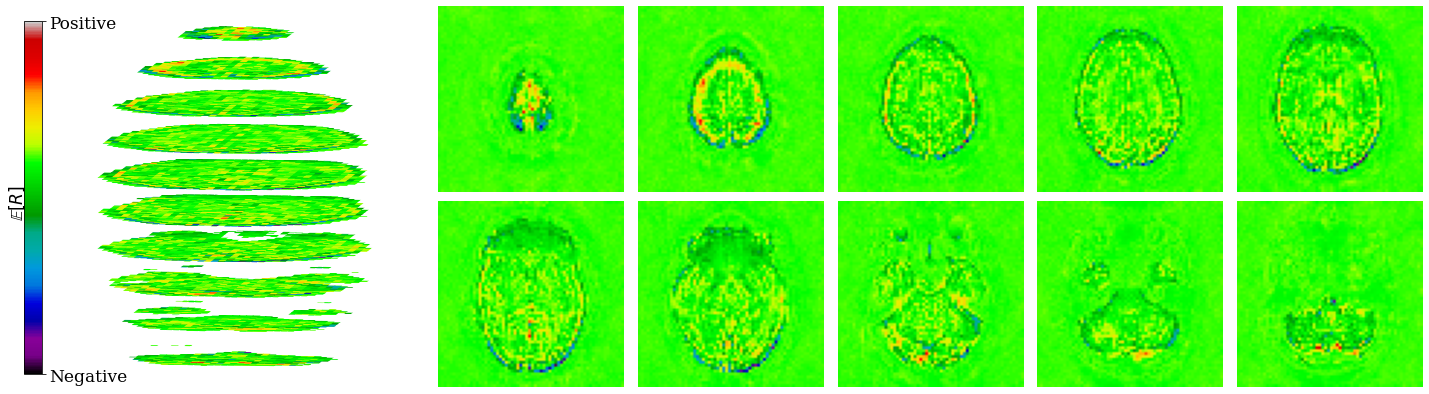

In [14]:
for instance_x, instance_y in train_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(np.mean(bnn_utils.epistemic_uncertainty(model, (instance_x, instance_y), T=100), axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Negative","Positive"])
    fig.show()
    break

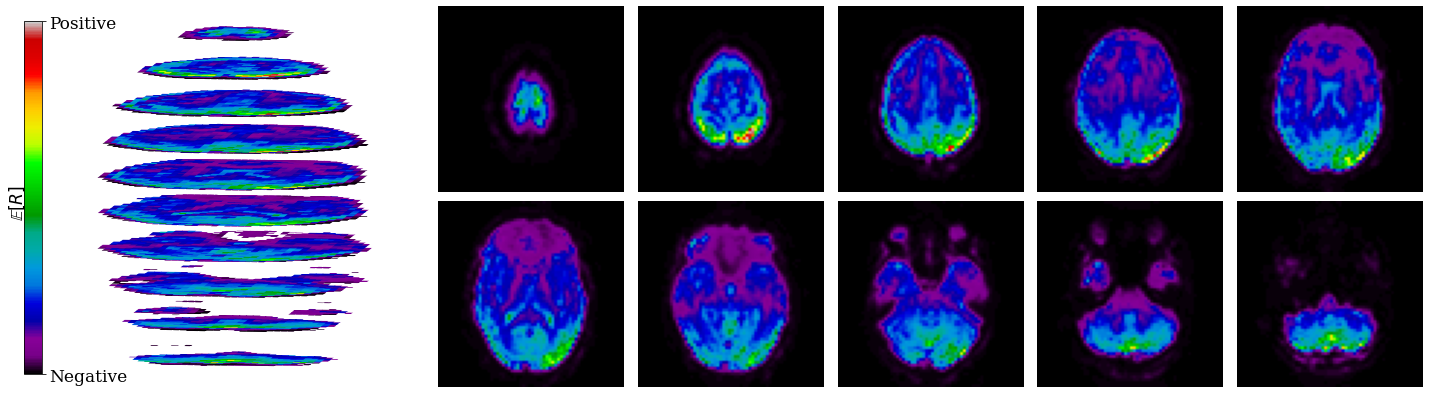

In [15]:
for instance_x, instance_y in train_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(np.mean(bnn_utils.aleatoric_uncertainty(model, (instance_x, instance_y), T=100), axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Negative","Positive"])
    fig.show()
    break

In [16]:
fmri_train.shape

(2296, 64, 64, 30, 1)

In [17]:
fmri_test.shape

(574, 64, 64, 30, 1)